### Homework 3: covariate shift and deep ensembles
CS-229 Spring 2023

In [16]:
import torch as t
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

import torch.nn.init as init
import torch.nn.functional as F

class MyClassifier(nn.Module):
    def __init__(self, input_size, output_size, weight_decay=0.0001, dropout_prob=0.5):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, output_size)

        # Random initialization of weights
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)

        self.weight_decay = weight_decay
        self.avg_parameters = {}  # Initialize avg_parameters as an empty dictionary
        self.dropout_prob = dropout_prob

    def forward(self, x):
        x = x.flatten(1)
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_prob, training=self.training)
        x = self.fc2(x)
        return x

    def l2_regularization_loss(self):
        l2_loss = 0.0
        for param in self.parameters():
            l2_loss += t.norm(param, p=2)
        return self.weight_decay * l2_loss

    def compute_avg_params(self):
        avg_dict = {}
        for param_name, param in self.named_parameters():
            avg_dict[param_name] = param.data.clone()

        self.avg_parameters = avg_dict

    def update_parameters(self, model):
        for param_name, param in self.named_parameters():
            if param_name in model.avg_parameters:
                param.data.copy_(model.avg_parameters[param_name])

class MyEnsemble(nn.Module):
    """TODO: 2 points, ensembled model
    This class implements an ensemble classifier from a list of models.
    Note that my viz code below assumes outputs are all logits. 
    """
    def __init__(self, models):
        super().__init__()
        self.models = models
        
    def forward(self, x):
        logits = [model(x) for model in self.models]
        avg_logits = t.stack(logits, dim=0).mean(dim=0)
        return avg_logits

device = t.device("cuda" if t.cuda.is_available() else "cpu")
device = t.device('mps') if t.backends.mps.is_available() else device

# Load data and construct train dataloaders
x_train, y_train, x_val, y_val, x_test, y_test = t.load('hw3_data_new.pt')
print('dataset sizes: ', x_train.shape, x_val.shape, x_test.shape)
batch_size = 100
train_ds = t.utils.data.TensorDataset(x_train, y_train)
train_dl = t.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

# Create and train models
n_models = 10
models = []
epochs = 10
dropout_prob = 0.5
for i in range(n_models):
    input_size = x_train.shape[1]  # Get the input size from the data
    output_size = int(y_train.max()) + 1  # Get the output size from the data
    model = MyClassifier(input_size, output_size, dropout_prob=dropout_prob)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for images, labels in train_dl:
            images = images.to(device)
            labels = labels.to(device).long()

            optimizer.zero_grad()
            predictions = model(images)
            loss = criterion(predictions, labels.squeeze())
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_dl)
    
    models.append(model)
    
# Stochastic Weight Averaging
swa_model = MyClassifier(input_size, output_size)  # Initialize SWA model
swa_model.compute_avg_params()  # Compute initial average parameters

for model in models:
    model.eval()
    swa_model.update_parameters(model)  # Update SWA model parameters with the individual models

model_ens = MyEnsemble([swa_model])  # Construct the ensemble model with SWA model as the only member


dataset sizes:  torch.Size([2000, 2]) torch.Size([2000, 2]) torch.Size([1000, 2])


### Output the accuracy and expected calibration error, for the model and ensemble

In [17]:
def accuracy(model, x, y):
    with t.no_grad():
        model.eval()
        predictions = t.argmax(model(x), dim=1)
        correct = (predictions == y).sum().item()
        total = y.size(0)
        acc = correct / total
    return acc

def ece(model, x, y, bins=10):
    with t.no_grad():
        model.eval()
        predictions = t.softmax(model(x), dim=1)
        confidences, predicted_labels = t.max(predictions, dim=1)
        bin_boundaries = t.linspace(0, 1, bins + 1)
        ece_val = 0.0
        for bin_lower, bin_upper in zip(bin_boundaries[:-1], bin_boundaries[1:]):
            in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
            if in_bin.any():
                accuracy_in_bin = accuracy(model, x[in_bin], y[in_bin])
                confidence_in_bin = confidences[in_bin].mean()
                ece_val += t.abs(accuracy_in_bin - confidence_in_bin) * in_bin.float().mean()
    return ece_val.item()

# TODO (1 point): run accuracy/ece on models/data to generate table.
# Don't forget to turn off grad tracking and use eval mode, 
# It's good practice even it doesn't make much difference here. 

# Feel free to use my code below that automatically outputs a nice table.
# Pandas can output latex tables too, very convenient. 

def vector_of_results(model):
    columns = ['Acc-train', 'Acc-val', 'Acc-test', 'ECE-train', 'ECE-val', 'ECE-test']
    results = t.zeros(6)
    results[0] = accuracy(model, x_train, y_train)
    results[1] = accuracy(model, x_val, y_val)
    results[2] = accuracy(model, x_test, y_test)
    results[3] = ece(model, x_train, y_train)
    results[4] = ece(model, x_val, y_val)
    results[5] = ece(model, x_test, y_test)
    return columns, results

with t.no_grad():
    results = t.zeros(6, 10)  # accuracy/ECE for train/val/test, then model index
    for i, model in enumerate(models):
        model.eval()
        columns, results[:, i] = vector_of_results(model)
    results = results.mean(axis=1)

    columns, ens_results = vector_of_results(model_ens)

df = pd.DataFrame(data=[results.numpy(), ens_results.numpy()], index=['Mean of models', 'Ensemble model'], columns=columns)
precision = '{:.3f}'.format
print(df.to_string(float_format=precision))

                Acc-train  Acc-val  Acc-test  ECE-train  ECE-val  ECE-test
Mean of models      0.994    0.994     0.779      0.010    0.011     0.059
Ensemble model      0.428    0.424     0.440      0.178    0.156     0.179


### Visualize the results

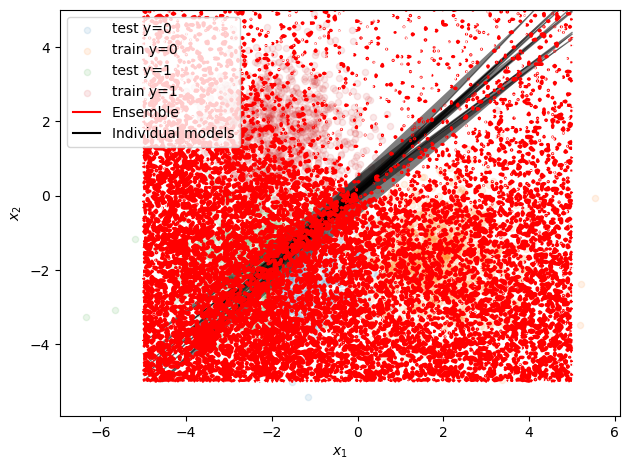

In [18]:
# Feel free to use my code or make your own. 

# viz datasets
fig, ax = plt.subplots()

for label in [0, 1]:
    ax.scatter(x_test[y_test==label, 0],x_test[y_test==label, 1], s=20, alpha=0.1, label='test y='+str(label))
    ax.scatter(x_train[y_train==label, 0],x_train[y_train==label, 1], s=20, alpha=0.1, label='train y='+str(label))

# Contour plot
k = 200
X = t.stack(t.meshgrid(t.linspace(-5, 5, k), t.linspace(-5, 5, k))).reshape((2, -1)).T
xx = X[:,0].reshape((k,k))
yy = X[:,1].reshape((k,k))

with t.no_grad():
    for i, model in enumerate(models):
        pred = t.softmax(model(X), axis=1)[:,0].numpy()
        zz = pred.reshape((k,k)).astype('float')
        contour = ax.contour(xx, yy, zz, levels=[0.5], alpha=0.5)

        contour.collections[0].set_color('black')
        contour.collections[0].set_linewidth(1)
        # contour.collections[0].set_label('model '+str(i))
        
    pred = t.softmax(model_ens(X), axis=1)[:,0].numpy()
    zz = pred.reshape((k,k)).astype('float')
    contour = ax.contour(xx, yy, zz, levels=[0.5], alpha=1)

    contour.collections[0].set_color('red')
    contour.collections[0].set_linewidth(2)

handles, labels = ax.get_legend_handles_labels()
from matplotlib.lines import Line2D
line = Line2D([0], [0], label='Ensemble', color='red')
line2 = Line2D([0], [0], label='Individual models', color='black')
# add manual symbols to auto legend
handles.extend([line, line2])
    
ax.legend(handles=handles, loc='upper left')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
fig.tight_layout()